# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Capstone Project Model Solution

Welcome! We are going to create and backtest a trading strategy based on candlestick patterns.

The notebook is structured as follows:
1. [Import the Data](#import)
2. [SL and TP](#sl_tp)
3. [Backtesting](#backtest)
4.  [Trade Sheet](#trades)
5.[Trading Signals](#signals)
6.[Strategy Returns](#strategy_returns)
7.[Portfolio Returns](#portfolio_returns)

## Import Libraries

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# For technical indicators
import talib as ta

<a id='import'></a>
## Import the Data

In [2]:
# Import price data of Apple stock
data_AAPL = pd.read_csv('../data_modules/AAPL_daily_2012_2022.csv', index_col=0)
data_TSLA = pd.read_csv('../data_modules/TSLA_daily_2012_2022.csv', index_col=0)

# Change index to datetime
data_AAPL.index = pd.to_datetime(data_AAPL.index, format='%d-%m-%Y')
data_TSLA.index = pd.to_datetime(data_TSLA.index, format='%d-%m-%Y')

<a id='sl_tp'></a>
## SL and TP

In [3]:
# Function for calculating SL and TP
def exit_values(data, index, entry_price, current_position, n):
    if current_position == 1:
        SL = data["Low"].iloc[index-n:index].min()
        TP = entry_price + (entry_price - SL) 
    if current_position == -1:
        SL = data["High"].iloc[index-n:index].max()
        TP = entry_price + (entry_price - SL)             
    return SL, TP

<a id='backtest'></a>
## Backtesting

In [4]:
# Function for backtesting
def backtesting(data):
    
    # Identify patterns
    data['marubozu_signal'] = ta.CDLMARUBOZU(data['Open'], data['High'], data['Low'], data['Close'])
    data['shooting_star_signal'] = ta.CDLSHOOTINGSTAR(data['Open'], data['High'], data['Low'], data['Close'])
    data['hammer_signal'] = ta.CDLHAMMER(data['Open'], data['High'], data['Low'], data['Close'])
    data['hanging_man_signal'] = ta.CDLHANGINGMAN(data['Open'], data['High'], data['Low'], data['Close'])

    # Generate entry signal
    data['signal'] = np.where((data['marubozu_signal'] | data['shooting_star_signal'] | data['hammer_signal'] | data['hanging_man_signal']) > 0, 1, 0)
    data['signal'] = np.where((data['marubozu_signal'] | data['shooting_star_signal'] | data['hammer_signal'] | data['hanging_man_signal']) < 0, -1, data['signal'])

    # Create dataframe for storing trades
    trades = pd.DataFrame(columns = ['Entry_Date', 'Entry_Type', 'Entry_Price', 'Exit_Date', 'Exit_Type', 'Exit_Price'])

    # Initialize current position, number of trades, cumulative pnl to 0
    current_position = 0
    trade_num = 0
    cum_pnl = 0

    # Set exit flag to False
    exit_flag = False
    
    for index in range(len(data)):
        # Check if there is no open position 
        if current_position == 0:
            if (data['signal'].iloc[index-1] == 1 or data['signal'].iloc[index-1] == -1):
                
                # Set entry date and entry price 
                entry_date = data.iloc[index].name
                entry_price = data['Open'].iloc[index]
                print(entry_date)
                if data['signal'].iloc[index-1] == 1:
                    entry_type = "Buy"
                    current_position = 1
                    SL, TP = exit_values(data, index, entry_price, current_position, n=10)

                if data['signal'].iloc[index-1] == -1:
                    entry_type = "Sell"
                    current_position = -1
                    SL, TP = exit_values(data, index, entry_price, current_position, n=10)

                # Increase number of trades by 1
                trade_num += 1   

                # Print trade details
                print("-"*30)
                print(f"Trade No: {trade_num} | Entry Date: {entry_date} | Entry Type: {entry_type} | Entry Price: {entry_price}")           

        # Check if there is an open position on the given timestamp
        if current_position != 0:
            if current_position == 1:
                if data['signal'].iloc[index-1] == -1 or data['Close'].iloc[index] > TP or data['Close'].iloc[index] < SL:
                    exit_flag = True
                    exit_type = "Sell"
                    current_position = 0


            if current_position == -1:
                if data['signal'].iloc[index-1] == 1 or data['Close'].iloc[index] > SL or data['Close'].iloc[index] < TP:
                    exit_flag = True
                    exit_type = "Buy"  

            # Check if exit flag is true
            if exit_flag: 

                # Set exit date and exit price
                exit_date = data.iloc[index].name
                exit_price = data['Close'].iloc[index]

                # Calculate pnl for the trade
                trade_pnl = round(exit_price - entry_price,2)

                # Calculate cumulative pnl 
                cum_pnl = round(cum_pnl,2) + trade_pnl

                # Append the trade to trades dataframe
                trades = trades.append({'Entry_Date': entry_date, 'Entry_Type': entry_type, 'Entry_Price': entry_price, 
                                        'Exit_Date': exit_date, 'Exit_Type': exit_type, 
                                        'Exit_Price': exit_price, 'PnL': trade_pnl}, ignore_index=True)

                # Update current position to 0 and set exit flag to False
                exit_flag = False
                current_position = 0
                
                # Print trade details
                print(f"Trade No: {trade_num} | Exit Type: {exit_type} | Date: {exit_date} | Exit Price: {exit_price} | PnL: {trade_pnl} | Cum PnL: {round(cum_pnl,2)}")                              
    
    return trades

In [5]:
trades_AAPL = backtesting(data_AAPL)
trades_TSLA = backtesting(data_TSLA)

2012-10-08 00:00:00
------------------------------
Trade No: 1 | Entry Date: 2012-10-08 00:00:00 | Entry Type: Sell | Entry Price: 23.102858
Trade No: 1 | Exit Type: Buy | Date: 2012-10-31 00:00:00 | Exit Price: 21.261429 | PnL: -1.84 | Cum PnL: -1.84
2012-11-26 00:00:00
------------------------------
Trade No: 2 | Entry Date: 2012-11-26 00:00:00 | Entry Type: Sell | Entry Price: 20.567858
Trade No: 2 | Exit Type: Buy | Date: 2012-11-26 00:00:00 | Exit Price: 21.054644 | PnL: 0.49 | Cum PnL: -1.35
2012-12-04 00:00:00
------------------------------
Trade No: 3 | Entry Date: 2012-12-04 00:00:00 | Entry Type: Sell | Entry Price: 20.77857
Trade No: 3 | Exit Type: Buy | Date: 2012-12-05 00:00:00 | Exit Price: 19.2425 | PnL: -1.54 | Cum PnL: -2.89
2012-12-06 00:00:00
------------------------------
Trade No: 4 | Entry Date: 2012-12-06 00:00:00 | Entry Type: Sell | Entry Price: 18.890715
Trade No: 4 | Exit Type: Buy | Date: 2013-01-24 00:00:00 | Exit Price: 16.089287 | PnL: -2.8 | Cum PnL: -5.

Trade No: 54 | Exit Type: Buy | Date: 2016-01-25 00:00:00 | Exit Price: 24.860001 | PnL: -0.28 | Cum PnL: 4.73
2016-01-26 00:00:00
------------------------------
Trade No: 55 | Entry Date: 2016-01-26 00:00:00 | Entry Type: Sell | Entry Price: 24.9825
Trade No: 55 | Exit Type: Buy | Date: 2016-01-27 00:00:00 | Exit Price: 23.355 | PnL: -1.63 | Cum PnL: 3.1
2016-02-19 00:00:00
------------------------------
Trade No: 56 | Entry Date: 2016-02-19 00:00:00 | Entry Type: Sell | Entry Price: 24.0
Trade No: 56 | Exit Type: Buy | Date: 2016-03-01 00:00:00 | Exit Price: 25.1325 | PnL: 1.13 | Cum PnL: 4.23
2016-03-03 00:00:00
------------------------------
Trade No: 57 | Entry Date: 2016-03-03 00:00:00 | Entry Type: Sell | Entry Price: 25.145
Trade No: 57 | Exit Type: Buy | Date: 2016-03-03 00:00:00 | Exit Price: 25.375 | PnL: 0.23 | Cum PnL: 4.46
2016-03-14 00:00:00
------------------------------
Trade No: 58 | Entry Date: 2016-03-14 00:00:00 | Entry Type: Sell | Entry Price: 25.477501
Trade No:

Trade No: 92 | Exit Type: Buy | Date: 2018-08-14 00:00:00 | Exit Price: 52.4375 | PnL: 0.92 | Cum PnL: 11.85
2018-08-29 00:00:00
------------------------------
Trade No: 93 | Entry Date: 2018-08-29 00:00:00 | Entry Type: Sell | Entry Price: 55.037498
Trade No: 93 | Exit Type: Buy | Date: 2018-08-29 00:00:00 | Exit Price: 55.744999 | PnL: 0.71 | Cum PnL: 12.56
2018-09-25 00:00:00
------------------------------
Trade No: 94 | Entry Date: 2018-09-25 00:00:00 | Entry Type: Buy | Entry Price: 54.9375
Trade No: 94 | Exit Type: Sell | Date: 2018-09-27 00:00:00 | Exit Price: 56.237499 | PnL: 1.3 | Cum PnL: 13.86
2018-09-28 00:00:00
------------------------------
Trade No: 95 | Entry Date: 2018-09-28 00:00:00 | Entry Type: Sell | Entry Price: 56.197498
Trade No: 95 | Exit Type: Buy | Date: 2018-10-01 00:00:00 | Exit Price: 56.814999 | PnL: 0.62 | Cum PnL: 14.48
2018-11-06 00:00:00
------------------------------
Trade No: 96 | Entry Date: 2018-11-06 00:00:00 | Entry Type: Buy | Entry Price: 50.4

Trade No: 145 | Exit Type: Buy | Date: 2021-12-07 00:00:00 | Exit Price: 171.179993 | PnL: 2.1 | Cum PnL: 73.23
2021-12-22 00:00:00
------------------------------
Trade No: 146 | Entry Date: 2021-12-22 00:00:00 | Entry Type: Sell | Entry Price: 173.039993
Trade No: 146 | Exit Type: Buy | Date: 2021-12-28 00:00:00 | Exit Price: 179.289993 | PnL: 6.25 | Cum PnL: 79.48
2022-02-02 00:00:00
------------------------------
Trade No: 147 | Entry Date: 2022-02-02 00:00:00 | Entry Type: Sell | Entry Price: 174.75
Trade No: 147 | Exit Type: Buy | Date: 2022-02-02 00:00:00 | Exit Price: 175.839996 | PnL: 1.09 | Cum PnL: 80.57
2022-02-03 00:00:00
------------------------------
Trade No: 148 | Entry Date: 2022-02-03 00:00:00 | Entry Type: Sell | Entry Price: 174.479996
Trade No: 148 | Exit Type: Buy | Date: 2022-02-03 00:00:00 | Exit Price: 172.899994 | PnL: -1.58 | Cum PnL: 78.99
2022-02-10 00:00:00
------------------------------
Trade No: 149 | Entry Date: 2022-02-10 00:00:00 | Entry Type: Sell | 

Trade No: 29 | Exit Type: Sell | Date: 2014-10-13 00:00:00 | Exit Price: 14.972667 | PnL: -1.71 | Cum PnL: 7.43
2014-10-22 00:00:00
------------------------------
Trade No: 30 | Entry Date: 2014-10-22 00:00:00 | Entry Type: Sell | Entry Price: 15.546
Trade No: 30 | Exit Type: Buy | Date: 2014-11-12 00:00:00 | Exit Price: 16.606667 | PnL: 1.06 | Cum PnL: 8.49
2014-11-14 00:00:00
------------------------------
Trade No: 31 | Entry Date: 2014-11-14 00:00:00 | Entry Type: Sell | Entry Price: 16.666668
Trade No: 31 | Exit Type: Buy | Date: 2014-11-14 00:00:00 | Exit Price: 17.245333 | PnL: 0.58 | Cum PnL: 9.07
2014-11-24 00:00:00
------------------------------
Trade No: 32 | Entry Date: 2014-11-24 00:00:00 | Entry Type: Sell | Entry Price: 16.346666
Trade No: 32 | Exit Type: Buy | Date: 2014-12-03 00:00:00 | Exit Price: 15.286667 | PnL: -1.06 | Cum PnL: 8.01
2014-12-19 00:00:00
------------------------------
Trade No: 33 | Entry Date: 2014-12-19 00:00:00 | Entry Type: Buy | Entry Price: 14.

2017-10-17 00:00:00
------------------------------
Trade No: 72 | Entry Date: 2017-10-17 00:00:00 | Entry Type: Buy | Entry Price: 23.393999
Trade No: 72 | Exit Type: Sell | Date: 2017-10-24 00:00:00 | Exit Price: 22.489332 | PnL: -0.9 | Cum PnL: 5.65
2017-11-01 00:00:00
------------------------------
Trade No: 73 | Entry Date: 2017-11-01 00:00:00 | Entry Type: Buy | Entry Price: 22.15
Trade No: 73 | Exit Type: Sell | Date: 2017-11-02 00:00:00 | Exit Price: 19.950666 | PnL: -2.2 | Cum PnL: 3.45
2017-11-08 00:00:00
------------------------------
Trade No: 74 | Entry Date: 2017-11-08 00:00:00 | Entry Type: Buy | Entry Price: 20.366667
Trade No: 74 | Exit Type: Sell | Date: 2017-12-11 00:00:00 | Exit Price: 21.927334 | PnL: 1.56 | Cum PnL: 5.01
2017-12-13 00:00:00
------------------------------
Trade No: 75 | Entry Date: 2017-12-13 00:00:00 | Entry Type: Buy | Entry Price: 22.728666
Trade No: 75 | Exit Type: Sell | Date: 2017-12-27 00:00:00 | Exit Price: 20.775999 | PnL: -1.95 | Cum PnL: 

Trade No: 121 | Exit Type: Buy | Date: 2021-04-13 00:00:00 | Exit Price: 254.106674 | PnL: 49.77 | Cum PnL: 42.26
2021-04-14 00:00:00
------------------------------
Trade No: 122 | Entry Date: 2021-04-14 00:00:00 | Entry Type: Buy | Entry Price: 256.899994
Trade No: 122 | Exit Type: Sell | Date: 2021-05-11 00:00:00 | Exit Price: 205.733337 | PnL: -51.17 | Cum PnL: -8.91
2021-05-24 00:00:00
------------------------------
Trade No: 123 | Entry Date: 2021-05-24 00:00:00 | Entry Type: Sell | Entry Price: 193.866669
Trade No: 123 | Exit Type: Buy | Date: 2021-06-24 00:00:00 | Exit Price: 226.606674 | PnL: 32.74 | Cum PnL: 23.83
2021-07-12 00:00:00
------------------------------
Trade No: 124 | Entry Date: 2021-07-12 00:00:00 | Entry Type: Sell | Entry Price: 220.733337
Trade No: 124 | Exit Type: Buy | Date: 2021-07-13 00:00:00 | Exit Price: 222.846664 | PnL: 2.11 | Cum PnL: 25.94
2021-07-21 00:00:00
------------------------------
Trade No: 125 | Entry Date: 2021-07-21 00:00:00 | Entry Type:

<a id='trades'></a>
## Trade Sheet

In [6]:
trades_AAPL

Entry_Date Entry_Type  Entry_Price  Exit_Date Exit_Type  Exit_Price    PnL
0   2012-10-08       Sell    23.102858 2012-10-31       Buy   21.261429  -1.84
1   2012-11-26       Sell    20.567858 2012-11-26       Buy   21.054644   0.49
2   2012-12-04       Sell    20.778570 2012-12-05       Buy   19.242500  -1.54
3   2012-12-06       Sell    18.890715 2013-01-24       Buy   16.089287  -2.80
4   2013-02-21       Sell    15.928571 2013-04-08       Buy   15.221786  -0.71
..         ...        ...          ...        ...       ...         ...    ...
157 2022-05-31        Buy   149.070007 2022-06-13      Sell  131.880005 -17.19
158 2022-07-08        Buy   145.259995 2022-07-22      Sell  154.089996   8.83
159 2022-07-29       Sell   161.240005 2022-07-29       Buy  162.509995   1.27
160 2022-08-16        Buy   172.779999 2022-08-30      Sell  158.910004 -13.87
161 2022-09-01       Sell   156.639999 2022-09-19       Buy  154.479996  -2.16

[162 rows x 7 columns]

In [7]:
trades_TSLA

Entry_Date Entry_Type  Entry_Price  Exit_Date Exit_Type  Exit_Price    PnL
0   2012-10-12       Sell     1.888000 2012-11-05       Buy    2.100000   0.21
1   2012-12-18        Buy     2.284000 2012-12-20      Sell    2.295333   0.01
2   2012-12-26        Buy     2.264000 2013-01-02      Sell    2.357333   0.09
3   2013-02-01        Buy     2.544667 2013-02-19      Sell    2.618667   0.07
4   2013-02-20        Buy     2.620000 2013-02-21      Sell    2.344000  -0.28
..         ...        ...          ...        ...       ...         ...    ...
143 2022-06-27        Buy   249.366669 2022-07-12      Sell  233.070007 -16.30
144 2022-07-19       Sell   245.000000 2022-07-21       Buy  271.706665  26.71
145 2022-08-11       Sell   296.513336 2022-08-23       Buy  296.453339  -0.06
146 2022-08-25       Sell   302.359985 2022-08-26       Buy  288.089996 -14.27
147 2022-09-08        Buy   281.299988 2022-09-09      Sell  299.679993  18.38

[148 rows x 7 columns]

<a id='signals'></a>
## Trading Signals

In [8]:
# Append signals as 1 and 0 on entry and exit dates
data_AAPL.loc[data_AAPL.index.isin(trades_AAPL.Entry_Date),'trade_signal'] = 1
data_AAPL.loc[data_AAPL.index.isin(trades_AAPL.Exit_Date),'trade_signal'] = 0
data_TSLA.loc[data_TSLA.index.isin(trades_AAPL.Entry_Date),'trade_signal'] = 1
data_TSLA.loc[data_TSLA.index.isin(trades_AAPL.Exit_Date),'trade_signal'] = 0

# Forward fill the NaN values
data_AAPL['trade_signal'] = data_AAPL['trade_signal'].ffill(axis = 0)
data_TSLA['trade_signal'] = data_TSLA['trade_signal'].ffill(axis = 0)

# Set the remaining NaN values to 0
data_AAPL['trade_signal'] = data_AAPL['trade_signal'].fillna(0)
data_TSLA['trade_signal'] = data_TSLA['trade_signal'].fillna(0)

<a id='strategy_returns'></a>
## Strategy Returns

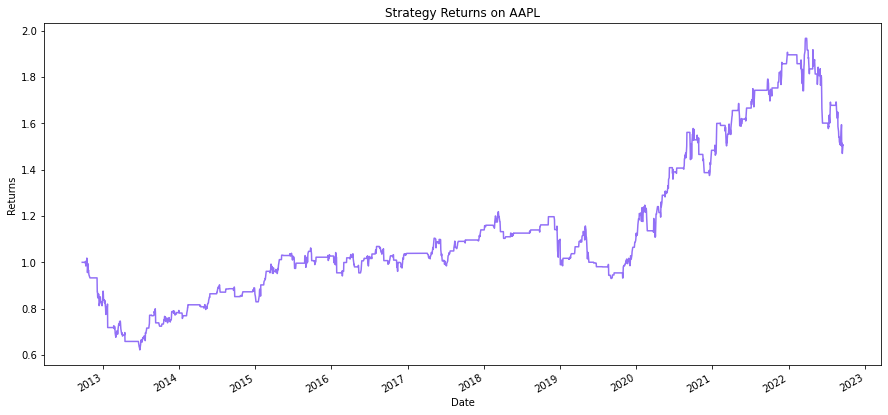

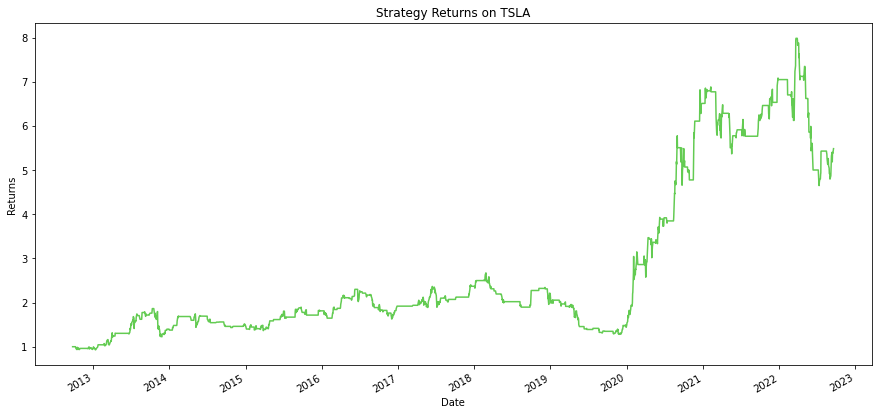

In [9]:
data_AAPL['strategy_returns'] = data_AAPL.trade_signal.shift(1) * data_AAPL.Close.pct_change()
(data_AAPL['strategy_returns']+1).cumprod().plot(color=np.random.rand(3,), figsize=(15, 7), ylabel='Returns', xlabel='Date')
plt.title(f'Strategy Returns on AAPL')
plt.show()

data_TSLA['strategy_returns'] = data_TSLA.trade_signal.shift(1) * data_TSLA.Close.pct_change()
(data_TSLA['strategy_returns']+1).cumprod().plot(color=np.random.rand(3,), figsize=(15, 7), ylabel='Returns', xlabel='Date')
plt.title(f'Strategy Returns on TSLA')
plt.show()

<a id='portfolio_returns'></a>
## Portfolio Returns

In [10]:
portfolio = pd.DataFrame()
portfolio["AAPL"] = data_AAPL['strategy_returns']
portfolio["TSLA"] = data_TSLA['strategy_returns']

portfolio.dropna(inplace=True)
portfolio.tail()

AAPL      TSLA
Date                          
2022-09-13 -0.058680 -0.040372
2022-09-14  0.009555  0.035874
2022-09-15 -0.018930  0.003767
2022-09-16 -0.010960 -0.001317
2022-09-19  0.025083  0.018856

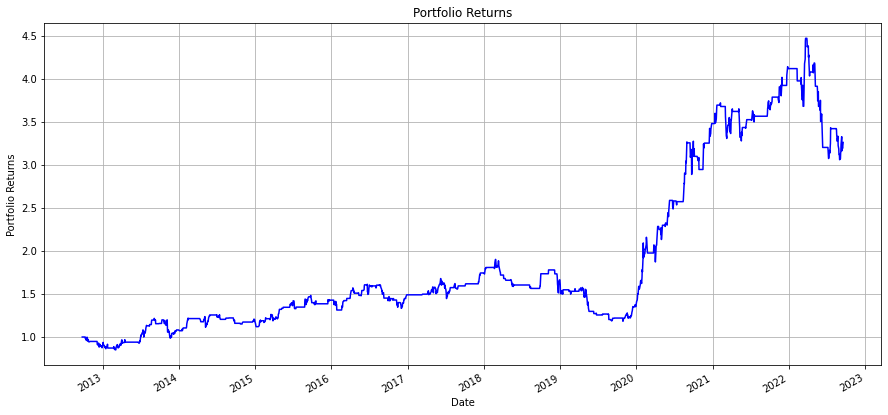

In [11]:
(portfolio.mean(axis=1)+1).cumprod().plot(color='blue',
                                          figsize=(15, 7), ylabel='Portfolio Returns', title='Portfolio Returns', xlabel='Date')
plt.grid()